### Mobile net

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [43]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUBA_VISIBLE_DEVICES'] = ''

np.random.seed(42)
random.seed(91939)
tf.random.set_seed(911)

In [3]:
train_path = 'data/train'
valid_path = 'data/validation'
test_path = 'data/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 766 images belonging to 5 classes.
Found 151 images belonging to 5 classes.
Found 212 images belonging to 5 classes.


In [5]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [6]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [7]:
x = mobile.layers[-6].output
output = Dense(units=5, activation='softmax')(x)

In [8]:
model = Model(inputs=mobile.input, outputs=output)

In [9]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [11]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(x=train_batches, validation_data=valid_batches, validation_steps=15, steps_per_epoch=75, epochs=10, verbose=2)

Epoch 1/10
75/75 - 25s - loss: 0.3842 - accuracy: 0.8713 - val_loss: 0.0736 - val_accuracy: 0.9800
Epoch 2/10
75/75 - 6s - loss: 0.0761 - accuracy: 0.9772 - val_loss: 0.0534 - val_accuracy: 0.9800
Epoch 3/10
75/75 - 7s - loss: 0.0517 - accuracy: 0.9866 - val_loss: 0.0335 - val_accuracy: 0.9933
Epoch 4/10
75/75 - 7s - loss: 0.0202 - accuracy: 0.9973 - val_loss: 0.0329 - val_accuracy: 0.9933
Epoch 5/10
75/75 - 6s - loss: 0.0248 - accuracy: 0.9960 - val_loss: 0.0291 - val_accuracy: 0.9933
Epoch 6/10
75/75 - 6s - loss: 0.0181 - accuracy: 0.9973 - val_loss: 0.0273 - val_accuracy: 0.9867
Epoch 7/10
75/75 - 6s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9933
Epoch 8/10
75/75 - 6s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9933
Epoch 9/10
75/75 - 6s - loss: 0.0102 - accuracy: 0.9987 - val_loss: 0.0170 - val_accuracy: 0.9933
Epoch 10/10
75/75 - 6s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9933


In [13]:
test_labels = test_batches.classes

In [14]:
predictions = model.predict(x=test_batches, verbose=0)

In [15]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=1))

In [16]:
test_batches.class_indices

{'airplane': 0, 'bicycle': 1, 'bus': 2, 'car': 3, 'motorcycle': 4}

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title=title
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white"
                if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

Confusion matrix, without normalization
[[40  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 40  0  0]
 [ 0  0  0 50  0]
 [ 1  0  1  0 40]]


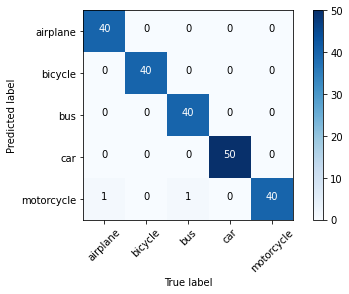

In [18]:
cm_plot_labels = ['airplane', 'bicycle', 'bus', 'car', 'motorcycle']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


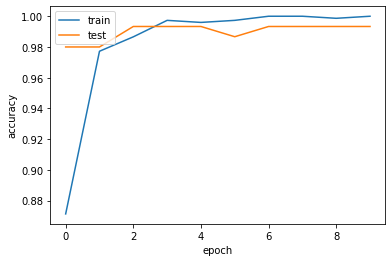

In [19]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title = "model accuracy"
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

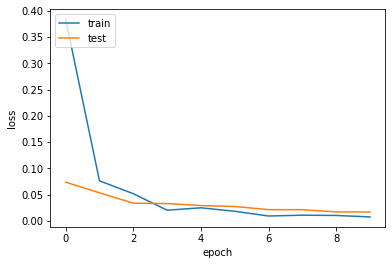

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title = 'model loss'
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()